<a href="https://colab.research.google.com/github/abigailcruz29/projeto-regressao-linear-t3/blob/main/Unidade_9_Regress%C3%A3o_Linear_Grupo_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## Carregamento do Dataset

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1OWVeTBaplaMt0GV1peHoQcMzeD1QAwEg'
insta_influencers = pd.read_csv(url)

In [ ]:
insta_influencers.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300.0,475800000.0,8700000.0,0.0139,6500000.0,2.900000e+10,Spain
1,2,kyliejenner,91,6900.0,366200000.0,8300000.0,0.0162,5900000.0,5.740000e+10,United States
2,3,leomessi,90,890.0,357300000.0,6800000.0,0.0124,4400000.0,6.000000e+09,Unknown
3,4,selenagomez,93,1800.0,342700000.0,6200000.0,0.0097,3300000.0,1.150000e+10,United States
4,5,therock,91,6800.0,334100000.0,1900000.0,0.0020,665300.0,1.250000e+10,United States


In [ ]:
# Verificar o nome das colunas, quantidade dos não nulos e tipo da informações presente nas colunas
insta_influencers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               200 non-null    int64  
 1   channel_info       200 non-null    object 
 2   influence_score    200 non-null    int64  
 3   posts              200 non-null    float64
 4   followers          200 non-null    float64
 5   avg_likes          200 non-null    float64
 6   60_day_eng_rate    200 non-null    float64
 7   new_post_avg_like  200 non-null    float64
 8   total_likes        200 non-null    float64
 9   country            200 non-null    object 
dtypes: float64(6), int64(2), object(2)
memory usage: 15.8+ KB


In [ ]:
# Verificando a Quantidade de Valores Nulos
insta_influencers.isna().sum()

,0
rank,0
channel_info,0
influence_score,0
posts,0
followers,0
avg_likes,0
60_day_eng_rate,0
new_post_avg_like,0
total_likes,0
country,0


In [ ]:
# Quantidade Influenciadores por País
insta_influencers["country"].value_counts()

,count
country,
United States,66
Unknown,62
Brazil,13
India,12
Indonesia,7
France,6
Spain,5
United Kingdom,4
Colombia,3


## Conversão dos Dados Simbólicos para Dados Numéricos Manipuláveis e Preenchimento dos Valores Ausentes

In [ ]:
# Função para converter valores com 'k', 'm', 'b' e '%' em números
def converter_para_numero(valor):
    if isinstance(valor, str):
        if 'k' in valor:
            return float(valor.replace('k', '')) * 1e3
        elif 'm' in valor:
            return float(valor.replace('m', '')) * 1e6
        elif 'b' in valor:
            return float(valor.replace('b', '')) * 1e9
        elif '%' in valor:
            return float(valor.replace('%', '')) / 100
    return valor

# Lista de colunas que precisam ser convertidas
colunas_para_converter = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']

# Aplicando a função de conversão em cada coluna relevante
for coluna in colunas_para_converter:
    insta_influencers[coluna] = insta_influencers[coluna].apply(converter_para_numero)

# Convertendo para numérico onde necessário, com erros coerção para NaN se houver falhas
insta_influencers['new_post_avg_like'] = pd.to_numeric(insta_influencers['new_post_avg_like'], errors='coerce')

# Preenchendo valores ausentes para colunas específicas
insta_influencers['country'].fillna('Unknown', inplace=True)
insta_influencers['60_day_eng_rate'].fillna(0, inplace=True)

# Verificar as mudanças aplicadas nas colunas
insta_influencers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               200 non-null    int64  
 1   channel_info       200 non-null    object 
 2   influence_score    200 non-null    int64  
 3   posts              200 non-null    float64
 4   followers          200 non-null    float64
 5   avg_likes          200 non-null    float64
 6   60_day_eng_rate    200 non-null    float64
 7   new_post_avg_like  200 non-null    float64
 8   total_likes        200 non-null    float64
 9   country            200 non-null    object 
dtypes: float64(6), int64(2), object(2)
memory usage: 15.8+ KB


<ipython-input-124-2793e81251ab>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  insta_influencers['country'].fillna('Unknown', inplace=True)
<ipython-input-124-2793e81251ab>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
insta_influencers.describe()

,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
count,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,2.000000e+02,2.000000e+02
mean,100.500000,81.820000,3499.850000,7.740950e+07,1.787104e+06,0.018925,1.208132e+06,3.658112e+09
std,57.879185,8.878159,3475.828158,7.368727e+07,2.193359e+06,0.033241,1.858322e+06,5.561939e+09
min,1.000000,22.000000,10.000000,3.280000e+07,6.510000e+04,0.000000,0.000000e+00,1.830000e+07
25%,50.750000,80.000000,947.500000,4.000000e+07,5.044000e+05,0.004100,1.957500e+05,9.968500e+08
50%,100.500000,84.000000,2100.000000,5.005000e+07,1.100000e+06,0.008650,5.321500e+05,2.000000e+09
75%,150.250000,86.000000,5025.000000,6.890000e+07,2.100000e+06,0.020325,1.325000e+06,3.900000e+09
max,200.000000,93.000000,17500.000000,4.758000e+08,1.540000e+07,0.264100,1.260000e+07,5.740000e+10


## Verificação do Coefienciente de Pearson e R^2 das Variáveis, para uma Regressão Linear Simples.

In [ ]:
# Criando um dicionário para armazenar os resultados de cada variável independente
resultados = {}

# Lista de variáveis independentes para análise individual
variaveis_independentes = ['posts', 'followers', 'avg_likes', 'new_post_avg_like']

# Loop para calcular os valores para cada variável independente separadamente
for variavel in variaveis_independentes:
    # Definindo a variável independente (X) como uma única coluna
    X = insta_influencers[[variavel]]
    y = insta_influencers['60_day_eng_rate']  # Variável dependente

    # Dividindo os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalizando os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Criando o modelo de Regressão Linear
    model = LinearRegression()

    # Treinando o modelo
    model.fit(X_train_scaled, y_train)

    # Fazendo previsões
    y_pred = model.predict(X_test_scaled)

    # Avaliando o modelo
    r2 = r2_score(y_test, y_pred)

    # Calculando o coeficiente de Pearson
    pearson_coef, _ = pearsonr(insta_influencers[variavel], insta_influencers['60_day_eng_rate'])

    # Salvando os resultados para a variável atual
    resultados[variavel] = {
        'Coeficiente de Pearson': pearson_coef,
        'R²': r2,
    }

# Convertendo o dicionário de resultados em um DataFrame
pd.DataFrame.from_dict(resultados, orient='index')

,Coeficiente de Pearson,R²
posts,-0.320220,0.122566
followers,-0.099169,0.014382
avg_likes,0.708407,0.431039
new_post_avg_like,0.869432,0.897243


### **Interpretação:**
1. **Variável posts**
* **Coeficiente de Pearson:** -0,3202
  * O coeficiente de Pearson negativo sugere uma correlação inversa fraca entre o número de posts e a variável dependente, ou seja, quanto mais posts, menor o resultado na variável dependente, mas com uma correlação baixa.
* **R^2:** 0,1226
  * O 𝑅^2 indica que cerca de 12,26% da variação na variável dependente é explicada pela quantidade de posts. Isso é baixo, sugerindo que a quantidade de posts não explica bem a variação na variável dependente.
2. **Variável followers**
* **Coeficiente de Pearson:** -0,0992
  * O coeficiente negativo indica uma correlação inversa muito fraca entre o número de seguidores e a variável dependente.
* **R^2:** 0,0144
  * O 𝑅^2 de 1,44% mostra que o número de seguidores tem praticamente nenhuma capacidade de explicar a variação na variável dependente.
3. **Variável avg_likes**
* **Coeficiente de Pearson:** 0,7084
  * O coeficiente positivo de 0,7084 indica uma correlação positiva forte entre a média de likes e a variável dependente.
* **𝑅^2:** 0,4310
  * O 𝑅^2 de 43,10% significa que a média de likes explica uma parte considerável (cerca de 43%) da variação na variável dependente, sendo um bom preditor.
4. **Variável new_post_avg_like**
* **Coeficiente de Pearson:** 0,8694
  * A correlação positiva muito alta (0,8694) indica uma correlação fortíssima e positiva entre a média de likes em novas postagens e a variável dependente.
* **𝑅^2:** 0,8972
 * O 𝑅^2 de 89,72% sugere que a média de likes nas novas postagens explica quase toda a variação na variável dependente, tornando-a um excelente preditor.

## Verificação da Melhor Combinação de Variáveis e do R^2, para uma Regressão Linear Múltipla.

In [ ]:
# Lista de variáveis independentes
variaveis_independentes = ['influence_score', 'posts', 'followers', 'avg_likes', 'new_post_avg_like', 'total_likes']

# Variável dependente
y = insta_influencers['60_day_eng_rate']

# Inicializando variáveis para armazenar os melhores resultados
melhor_r2 = -float("inf")  # Começa com o pior valor de R² possível
melhor_combinacacao = None

# Loop para testar todas as combinações de variáveis independentes
for i in range(1, len(variaveis_independentes) + 1):
    for combo in combinations(variaveis_independentes, i):
        # Definindo as variáveis independentes para a combinação atual
        X = insta_influencers[list(combo)]

        # Dividindo os dados em conjuntos de treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Normalizando os dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Criando e treinando o modelo
        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        # Calculando o R²
        y_pred = modelo.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)

        # Salvando a combinação se tiver o melhor R² até agora
        if r2 > melhor_r2:
            melhor_r2 = r2
            melhor_combinacacao = combo

# Exibindo o melhor R² e a combinação de variáveis que o gerou
print(f"Melhor R² Score: {melhor_r2}")
print(f"Melhor Combinação de Variáveis Independentes: {melhor_combinacacao}")

Melhor R² Score: 0.9505058193050772
Melhor Combinação de Variáveis Independentes: ('posts', 'followers', 'avg_likes', 'new_post_avg_like')


### **Interpretação**
1. **Melhor 𝑅^2: 0,9505**

* O valor do 𝑅^2 de 0,9505 indica que essa combinação de variáveis independentes explica 95,05% da variação na variável dependente.

* Esse valor é extremamente alto, sugerindo que o modelo de regressão múltipla com essas variáveis captura quase toda a variação na variável dependente, ou seja, a combinação fornece um modelo altamente explicativo e robusto.

2. **Melhor Combinação de Variáveis Independentes: ('posts', 'followers', 'avg_likes', 'new_post_avg_like')**

* A inclusão de dessas as variáveis parece aumentar a capacidade explicativa do modelo, sugerindo que, juntas, essas variáveis fornecem uma visão mais completa e precisa do comportamento da variável dependente do que individualmente.

### **Resumo**
A regressão linear múltipla com as variáveis posts, followers, avg_likes, e new_post_avg_like resulta em um modelo com alto poder preditivo e explicativo, demonstrado pelo alto 𝑅^2.

Este resultado implica que, embora algumas dessas variáveis tenham mostrado correlações fracas individualmente, sua combinação melhora significativamente a previsão. Isso pode ocorrer porque a interação entre essas variáveis captura aspectos diferentes e complementares da dinâmica da variável dependente.

## Plot da Relação entre Variáveis Independentes e a Taxa de Engajamento

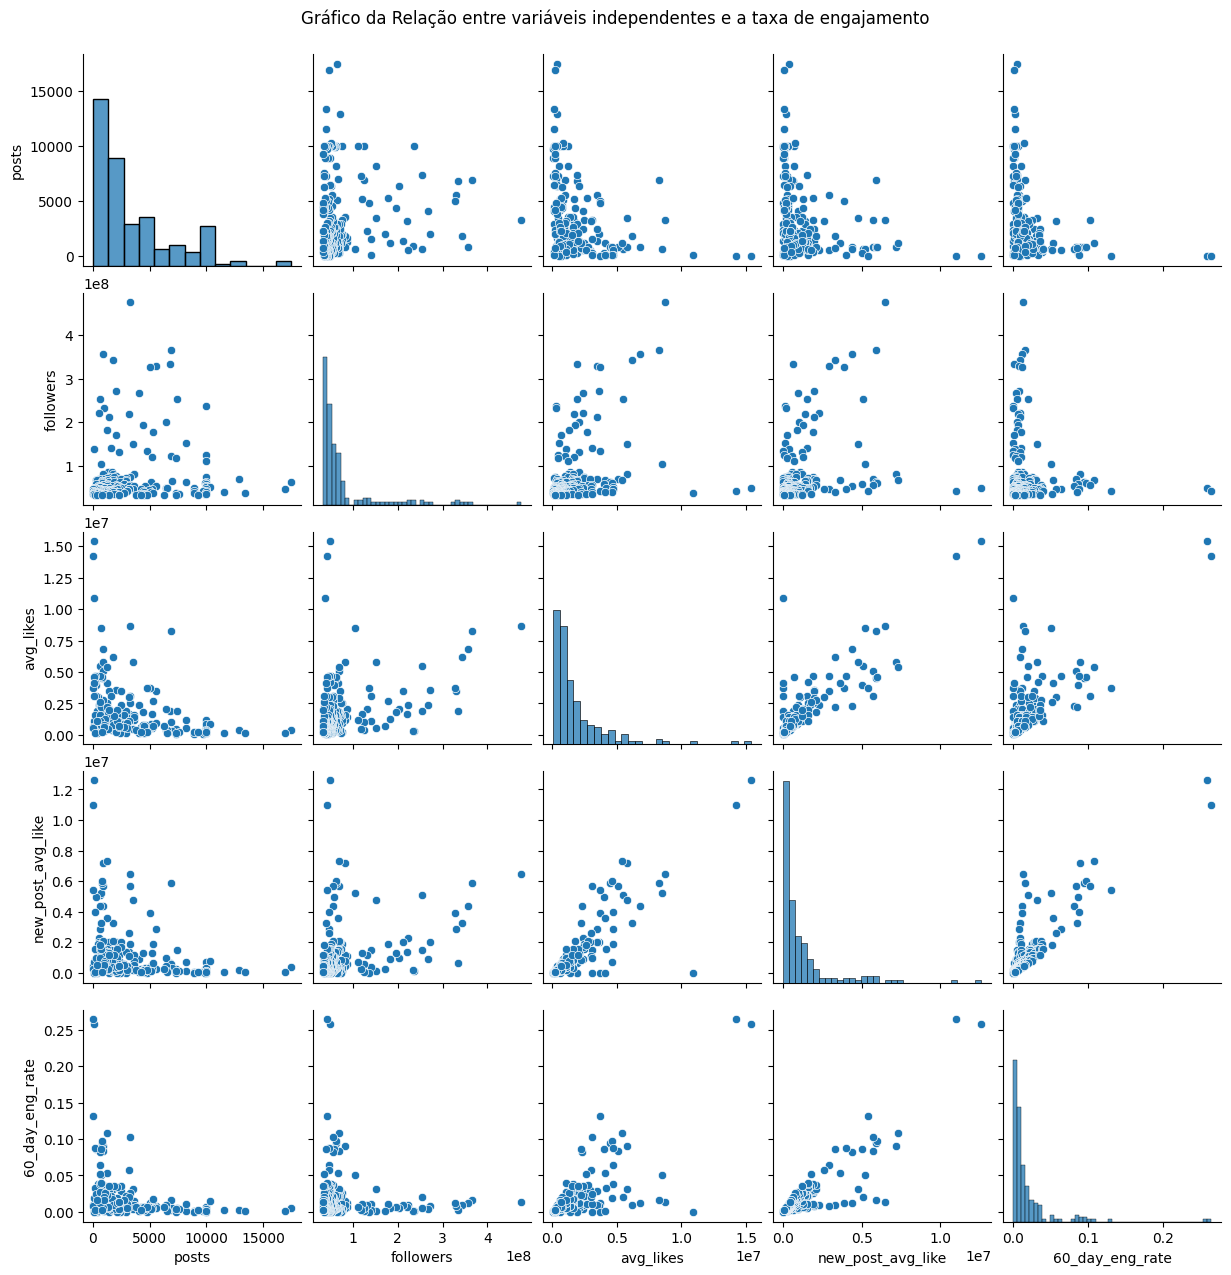

In [ ]:
def plot_feature_relationships(data: pd.DataFrame):
    """
    Plota gráficos de dispersão para visualizar as relações entre as variáveis independentes e a dependente.
    """
    sns.pairplot(data[['posts', 'followers', 'avg_likes', 'new_post_avg_like', '60_day_eng_rate']], kind='scatter')
    plt.suptitle("Gráfico da Relação entre variáveis independentes e a taxa de engajamento", y=1.02)
    plt.show()

# Plotando as relações entre as variáveis
plot_feature_relationships(insta_influencers)

## Plot da Matriz Correlação

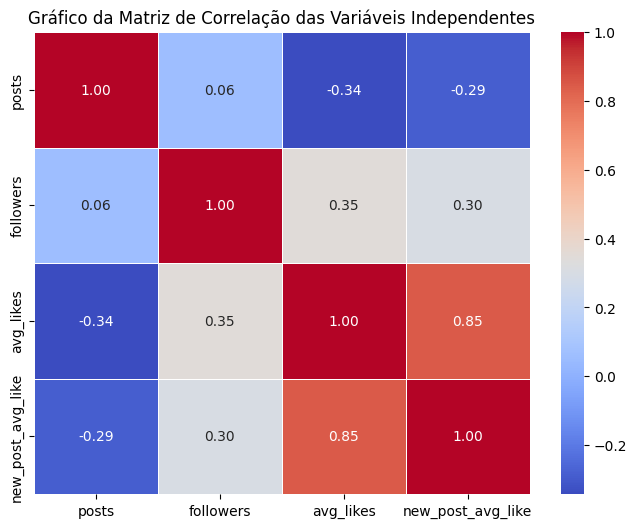

In [ ]:
def plot_correlation_matrix(data: pd.DataFrame):
    """
    Plota a matriz de correlação das variáveis independentes.
    """
    correlation_matrix = data.corr(method="pearson")
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Gráfico da Matriz de Correlação das Variáveis Independentes')
    plt.show()

# Plotando a matriz de correlação
plot_correlation_matrix(insta_influencers[['posts', 'followers', 'avg_likes', 'new_post_avg_like']])

## Análise Métricas de Avaliação(R^2, MSE e MAE) e Visualização dos Resultados nos Gráficos

<ipython-input-159-ae7078307df2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_followers'] = np.log(data_clean['followers'] + 1)
<ipython-input-159-ae7078307df2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_posts'] = np.log(data_clean['posts'] + 1)



Desempenho do modelo - Mínimos Quadrados Ordinários (MQO):
 R² no Treinamento: 0.9568 
 MSE no Treinamento: 0.0000 
 MAE no Treinamento: 0.0042

 R² no Teste: 0.9424 
 MSE no Teste: 0.0001 
 MAE no Teste: 0.0049


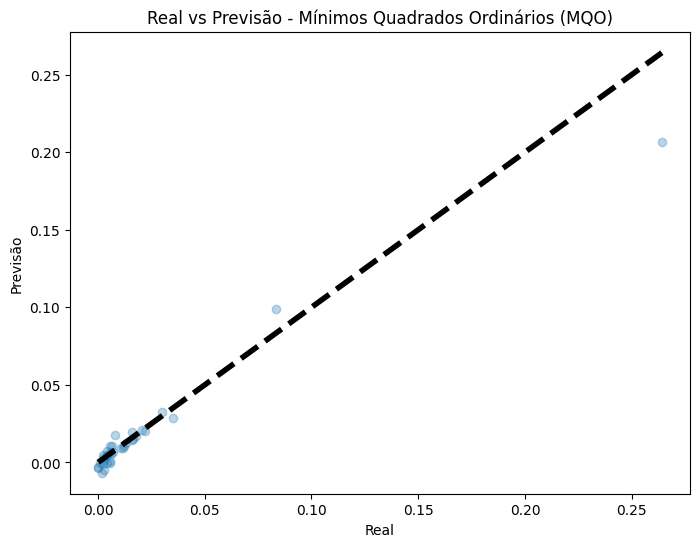

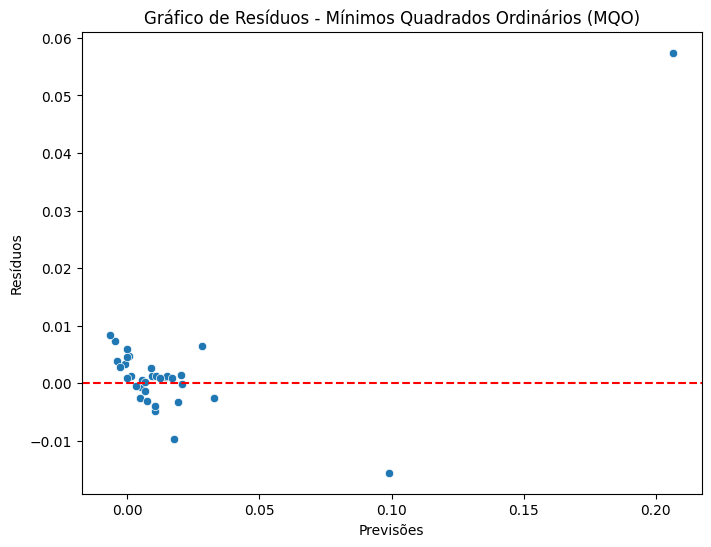


Melhor alpha para Ridge: {'alpha': 0.615848211066026}

Desempenho do modelo - Ridge:
 R² no Treinamento: 0.9567 
 MSE no Treinamento: 0.0000 
 MAE no Treinamento: 0.0042

 R² no Teste: 0.9421 
 MSE no Teste: 0.0001 
 MAE no Teste: 0.0049


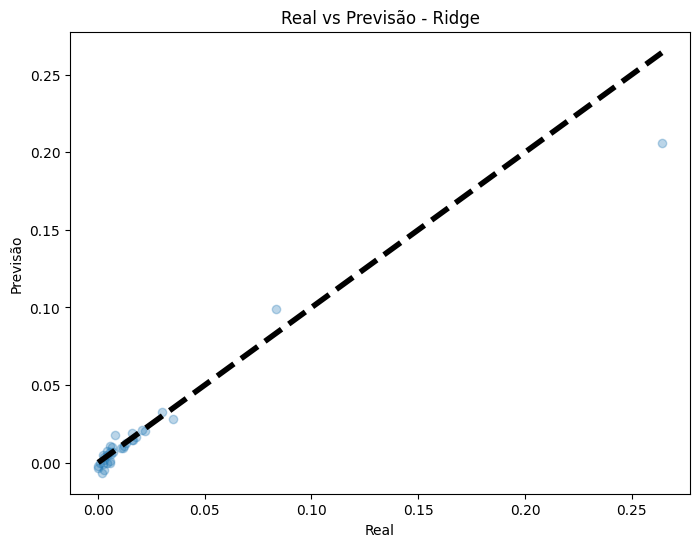

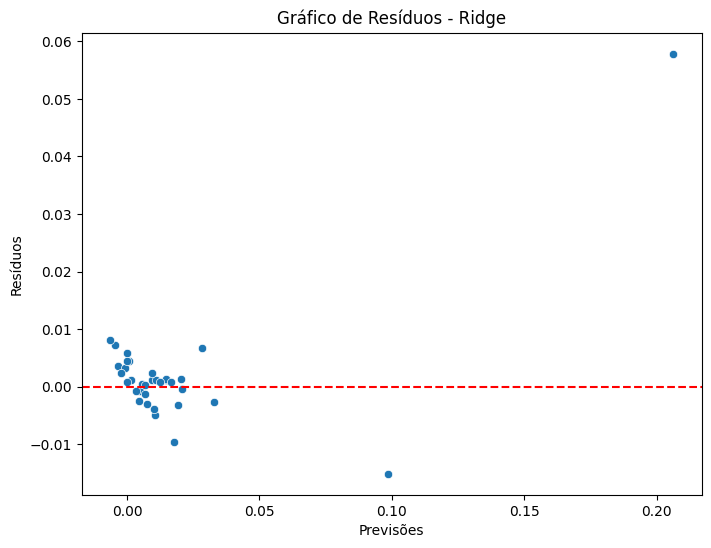


Melhor alpha para Lasso: {'alpha': 0.0006951927961775605}

Desempenho do modelo - Lasso:
 R² no Treinamento: 0.9551 
 MSE no Treinamento: 0.0000 
 MAE no Treinamento: 0.0039

 R² no Teste: 0.9376 
 MSE no Teste: 0.0001 
 MAE no Teste: 0.0043


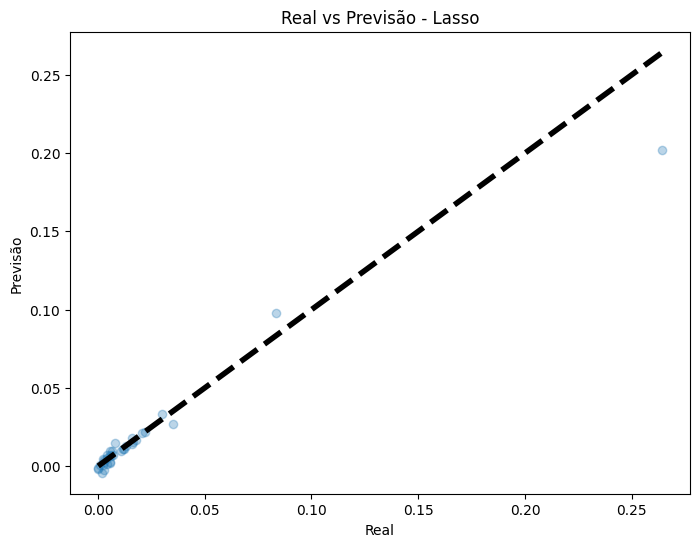

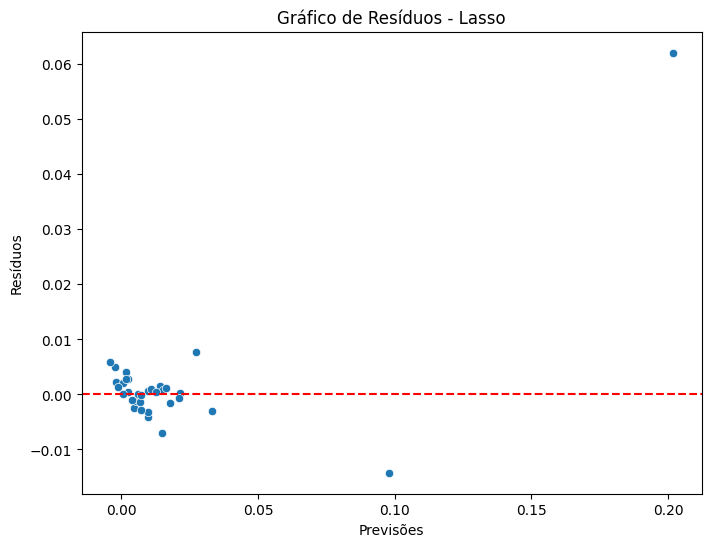

In [ ]:
def load_and_preprocess_data(data: pd.DataFrame):
    """
    Carrega e preprocessa os dados, incluindo transformação logarítmica e remoção de outliers.
    """
    # Definindo a variável dependente e as variáveis independentes
    y = data['60_day_eng_rate']
    X = data[['posts', 'followers', 'avg_likes', 'new_post_avg_like']]

    # Removendo outliers na variável 'followers'
    Q1 = data['followers'].quantile(0.25)
    Q3 = data['followers'].quantile(0.75)
    IQR = Q3 - Q1
    data_clean = data[(data['followers'] >= (Q1 - 1.5 * IQR)) &
                      (data['followers'] <= (Q3 + 1.5 * IQR))]

    # Transformação logarítmica das variáveis 'followers' e 'posts'
    data_clean['log_followers'] = np.log(data_clean['followers'] + 1)
    data_clean['log_posts'] = np.log(data_clean['posts'] + 1)

    # Atualizando as variáveis independentes
    X_transformed = data_clean[['log_posts', 'log_followers', 'avg_likes', 'new_post_avg_like']]
    y = y.loc[data_clean.index]  # Garantir consistência de amostras

    return X_transformed, y

def normalize_data(X: pd.DataFrame):
    """
    Normaliza os dados utilizando o StandardScaler e retorna como DataFrame.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # Mantém os nomes das colunas
    return X_scaled, scaler

def select_features(X_scaled: pd.DataFrame, y: pd.Series):
    """
    Realiza a seleção de variáveis mais relevantes usando f_regression.
    """
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_scaled, y)
    scores = selector.scores_
    selected_features = X_scaled.columns[selector.get_support()]  # Evita erro de dimensão

    return selected_features

def evaluate_metrics(y_true: pd.Series, y_pred: np.ndarray):
    """
    Avalia o desempenho do modelo utilizando as métricas R², MSE e MAE.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, mae

def plot_residuals(y_true: pd.Series, y_pred: np.ndarray, model_name: str):
    """
    Plota os resíduos para avaliar a performance do modelo.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Previsões')
    plt.ylabel('Resíduos')
    plt.title(f'Gráfico de Resíduos - {model_name}')
    plt.show()

def grid_search_regularization(X_train: np.ndarray, y_train: pd.Series, model, param_grid: dict):
    """
    Realiza a busca em grade para encontrar o melhor parâmetro de regularização.
    """
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    return grid_search

def train_and_evaluate_model(X_train: np.ndarray, X_test: np.ndarray, y_train: pd.Series, y_test: pd.Series, model, model_name: str):
    """
    Treina o modelo e avalia seu desempenho utilizando R², MSE e MAE.
    """
    model.fit(X_train, y_train)

    # Previsões
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Avaliação do desempenho
    r2_train, mse_train, mae_train = evaluate_metrics(y_train, y_pred_train)
    r2_test, mse_test, mae_test = evaluate_metrics(y_test, y_pred_test)

    print(f"\nDesempenho do modelo - {model_name}:")
    print(f" R² no Treinamento: {r2_train:.4f} \n MSE no Treinamento: {mse_train:.4f} \n MAE no Treinamento: {mae_train:.4f}")
    print(f"\n R² no Teste: {r2_test:.4f} \n MSE no Teste: {mse_test:.4f} \n MAE no Teste: {mae_test:.4f}")

    # Gráfico Real vs Previsão
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Real')
    plt.ylabel('Previsão')
    plt.title(f'Real vs Previsão - {model_name}')
    plt.show()

    # Visualização dos resíduos
    plot_residuals(y_test, y_pred_test, model_name)

    return model, r2_test

def main(data: pd.DataFrame):
    """
    Função principal para carregar os dados, realizar as transformações, treinar e avaliar os modelos.
    """
    # Carregando e preprocessando os dados
    X, y = load_and_preprocess_data(data)

    # Normalizando os dados
    X_scaled, scaler = normalize_data(X)

    # Seleção de features
    selected_features = select_features(X_scaled, y)

    # Dividindo os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Mínimos Quadrados Ordinários (MQO)
    ols_model = LinearRegression()
    ols_model, r2_test_ols = train_and_evaluate_model(X_train, X_test, y_train, y_test, ols_model, "Mínimos Quadrados Ordinários (MQO)")

    # Parametros para a busca em grade
    param_grid = {'alpha': np.logspace(-4, 4, 20)}

    # Busca em grade para Ridge
    ridge_grid = grid_search_regularization(X_train, y_train, Ridge(), param_grid)
    print(f"\nMelhor alpha para Ridge: {ridge_grid.best_params_}")
    ridge_best = Ridge(alpha=ridge_grid.best_params_['alpha'])
    ridge_best, r2_test_ridge = train_and_evaluate_model(X_train, X_test, y_train, y_test, ridge_best, "Ridge")

    # Busca em grade para Lasso
    lasso_grid = grid_search_regularization(X_train, y_train, Lasso(), param_grid)
    print(f"\nMelhor alpha para Lasso: {lasso_grid.best_params_}")
    lasso_best = Lasso(alpha=lasso_grid.best_params_['alpha'])
    lasso_best, r2_test_lasso = train_and_evaluate_model(X_train, X_test, y_train, y_test, lasso_best, "Lasso")

if __name__ == "__main__":
    # Exemplo de como usar a função principal
    # Insta influencers é um DataFrame previamente carregado
    main(insta_influencers)

### **Interpreção:** Ao analisar os resultados dos modelos de Mínimos Quadrados Ordinários (MQO), Ridge e Lasso, observamos que tanto no conjunto de treinamento quanto no de teste, o valor de R² supera 0.94, indicando uma forte capacidade de explicação da variabilidade dos dados.
### Além disso, os valores de MSE e MAE ficam abaixo de 0.05, o que sugere um erro de previsão muito baixo. Esses indicadores apontam para a construção de um modelo robusto e preciso, capaz de prever com alta acurácia.